# **Modeling - Real vs Fake News**

<small>Written by: Ali Tobah - tobah@umich.edu</small>

In [1]:
# Uncomment to install as needed
#!pip install empath
#!pip install scattertext

# Recommended by Scattertext authors,
# "in order to take full advantage of Scattertext"
# but might not need to install; might be
# installed automatically.
#!pip install jieba
#!pip install spacy
#!pip install astropy
#!pip install flashtext
#!pip install gensim
#!pip install umap-learn

In [2]:
import pandas as pd
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from empath import Empath
lexicon = Empath()
import scattertext as st
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Constants
RED = '#d62728'    # From Vega color schemes category10
GREEN = '#4daf4a'    # From Vega color schemes set1
RANDOM_STATE = 0
dirPath = 'data/processed'

### **Function definitions**

In [4]:
def splitStratify(originalDF, stratify=False):
    '''
    Splits the data while stratifying on domain if applicable

    Called by: modelData()
    Calls: None

    Args:
      - Original data as a dataframe
      - Boolean indicating whether to stratify by domain
    Returns:
      - Training df
      - Testing df
      - Chart of training data by label and domain
      
    Notes:
      - Prints training and test dataframe shapes
      - Prints fake (1) / real (0) label counts in the training data
  '''

    dataDF = originalDF.copy()

    # Split with stratification on Domain if applicable
    if stratify == False:
        trainDF, testDF = train_test_split(dataDF, test_size=0.2, random_state=RANDOM_STATE)
    else:
        trainDF, testDF = train_test_split(dataDF, test_size=0.2,
                                      random_state=RANDOM_STATE, stratify=dataDF[['Domain']])

    # Check the sizes
    print("Training and test dataframe shapes:", trainDF.shape, testDF.shape)

    # Check balance of labels in the training data
    print('Fake (1) / real (0) label counts in the training data:', Counter(trainDF['intLabel']))

    print('\n')

    # This is admittedly a kluge, but still better than the
    # alternative: Convert labels back to text in the training
    # df in a new column, just for the chart, then drop it.
    trainDF['Labels'] = trainDF['intLabel'].map({1: 'fake', 0: 'real'})

    domainColor = ['fake', 'real']
    rangeColor = [RED, GREEN]

    # Do a visual check
    trainChartDF = trainDF.groupby(['Domain', 'Labels']).count().rename(columns={'Text': 'Number of Articles'}).reset_index()
    trainChart = alt.Chart(trainChartDF).mark_bar().encode(
        x = alt.X('Number of Articles:Q'),
        y = alt.Y('Labels:N', title=None, axis=alt.Axis(labels=False, tickSize=0)),
        color = alt.Color('Labels:N', scale=alt.Scale(domain=domainColor, range=rangeColor)),
        row = alt.Row('Domain:N')
        ).properties(
            title = 'Training data by domain',
            height=25,
            width=300
        ).configure_axis(
            labelFontSize=10,
            titleFontSize=12
        ).configure_title(
            fontSize=15
        ).configure_legend(
            titleFontSize=12
        )
    
    trainDF = trainDF.drop(['Labels'], axis=1)

    return trainDF, testDF, trainChart

In [5]:
def plot_confusion_matrix(y_test=None, y_pred=None, labels=None):
    """
    Plots the confusion matrix for the given model results (in line plot)

    Called by: getF1Scores()
    Calls: None

    Args:
        y_test (list or series): Real labels for the test dataset
        y_pred (list or series): Predicted labels for the test dataset
        labels (list): Classification label names
    Returns:
        Confusion matrix plot
    
    Notes: Slightly revised from CGregg's code
    """
    conf_matrix = confusion_matrix(y_test, y_pred, labels=labels, normalize='all')
    cm_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                                    display_labels=['real', 'fake']
                                    )

    confPlot = cm_disp.plot(cmap='Purples')

    return confPlot

In [6]:
# Prepare a text vectorizer and train
# logistic regression and linearSVC models
def getF1Scores(trainDFVar, testDFVar, stopWords=None, min_df=1, ngrams=1):
    '''
    Prepares the vectorizer, trains the models and returns F1 scores and accuracy

    Called by: modelData()
    Calls: plot_confusion_matrix()

    Args:
      - Training df
      - Test df
      - StopWords
      - Minimum document frequency for TfidfVectorizer
      - Maximum ngrams for TfidfVectorizer
    Returns:
      - Text vectorizer
      - Xtrain array after fit and transform with vectorizer, addition of extra features
      - Trained Logistic Regression model
      - Trained LinearSVC model
      - The confusion matrix for the Logistic Regression model
      
    Notes:
      - Prints F1 scores and accuracy for a dummy (random) classifier, a Logistic Regression model and a LinearSVC model
      - Mostly default parameters for vectorizer and models
    '''

    # Vectorize the training text
    textVec = TfidfVectorizer(stop_words=stopWords, min_df=min_df, ngram_range=(1,ngrams))
    Xtrain = textVec.fit_transform(trainDFVar.Text)
    
    # If there are features other than the vectorized text, scale
    # them and convert to sparse array (same type as Xtrain),
    # then merge with Xtrain
    tempDF = trainDFVar.drop(['Text', 'Domain', 'intLabel'], axis=1)
    if tempDF.shape[1] != 0:
        tempArray = sparse.csr_matrix(tempDF.values)
        tempScaler = preprocessing.MaxAbsScaler().fit(tempArray)
        tempArray = tempScaler.transform(tempArray)
    
        # Merge the two sparse arrays
        Xtrain = sparse.hstack([Xtrain, tempArray])



    # Repeat for the test data
    Xtest = textVec.transform(testDFVar.Text)

    tempDF = testDFVar.drop(['Text', 'Domain', 'intLabel'], axis=1)
    if tempDF.shape[1] != 0:
        tempArray = sparse.csr_matrix(tempDF.values)
        tempArray = tempScaler.transform(tempArray)

        Xtest = sparse.hstack([Xtest, tempArray])


    # Get the labels
    ytrain = list(trainDFVar.intLabel)
    ytest = list(testDFVar.intLabel)
    
    # Train a dummy classifier for comparison
    clfRandom = DummyClassifier(strategy="stratified", random_state=RANDOM_STATE)
    clfRandom.fit(Xtrain, ytrain)

    # Train a logistic regression classifier
    # and an SVC classifier

    clfLR = LogisticRegression(random_state=RANDOM_STATE)
    clfLR.fit(Xtrain, ytrain)

    clfSVC = LinearSVC(loss='hinge', C=0.4, random_state=RANDOM_STATE)
    clfSVC.fit(Xtrain, ytrain)

    # Get predictions and F1 scores

    predRandom = clfRandom.predict(Xtest)
    predLR = clfLR.predict(Xtest)
    predSVC = clfSVC.predict(Xtest)

    f1Rand = f1_score(ytest, predRandom)
    accRand = clfRandom.score(Xtest, ytest)
    print('Random f1 score:', f1Rand, '...', 'Accuracy:', accRand)
    f1LR = f1_score(ytest, predLR)
    accLR = clfLR.score(Xtest, ytest)
    print('Logistic regression f1 score:', f1LR, '...', 'Accuracy:', accLR)
    f1SVC = f1_score(ytest, predSVC)
    accSVC = clfSVC.score(Xtest, ytest)
    print('SVC f1 score:', f1SVC, '...', 'Accuracy:', accSVC)

    print('\n')

    # Create the confusion matrix for the Logistic Regression model
    confMtxPlot = plot_confusion_matrix(ytest, predLR, clfLR.classes_)

    # Return the vectorizer, the models for use
    # in the explanation and the confusion matrix
    return textVec, Xtrain, clfLR, clfSVC, confMtxPlot


In [7]:
# Explain the predictions
def explainPred(featList, trainArray, clfLR, clfSVC):
    '''
    Plots highest coefficients

    Called by: modelData()
    Calls: None
    
    Args:
       - List of feature names
       - Transformed training data array
       - Trained Logistic Regression model
       - Trained LinearSVC model
    Returns:
      - Horizontally concatenated chart showing the weights for each model for the 20 most important features
    '''

    domainColor = ['fake', 'real']
    rangeColor = [RED, GREEN]

    # Standardized list of Logistic Regression model coefficients
    stdCoefListLR = list((np.std(trainArray.toarray(), 0) * clfLR.coef_)[0])

    # Create dataframe with feature names and get top 20
    LRfeatCoefDF = pd.DataFrame({'Features': featList, 'LRWeights': stdCoefListLR})
    LRfeatCoefDF = LRfeatCoefDF.sort_values(by='LRWeights', key=abs, ascending=False)
    LRfeatCoefDF20 = LRfeatCoefDF.head(20)
    # Add a label column to get the legend
    LRfeatCoefDF20['Labels'] = LRfeatCoefDF20['LRWeights'].apply(lambda x: 'fake' if x > 0 else 'real')

    LRChart = alt.Chart(LRfeatCoefDF20).mark_bar().encode(
        x = alt.X("LRWeights:Q"),
        y = alt.Y("Features:N", sort=None, axis=alt.Axis(grid=True)),
        color = alt.Color('Labels', scale=alt.Scale(domain=domainColor, range=rangeColor))
    ).properties(width=250, height=300)

    # Standardized list of LinearSVC model coefficients
    stdCoefListSVC = list((np.std(trainArray.toarray(), 0) * clfSVC.coef_)[0])

    # Create dataframe with feature names and get top 20
    SVCfeatCoefDF = pd.DataFrame({'Features': featList, 'SVCWeights': stdCoefListSVC})
    SVCfeatCoefDF = SVCfeatCoefDF.sort_values(by='SVCWeights', key=abs, ascending=False)
    SVCfeatCoefDF20 = SVCfeatCoefDF.head(20)

    # Did not add a labels column here, and coded
    # the color using a condition instead. Just a
    # different way of doing it.
    SVCChart = alt.Chart(SVCfeatCoefDF20).mark_bar().encode(
        x = alt.X("SVCWeights:Q"),
        y = alt.Y("Features:N", sort=None, axis=alt.Axis(grid=True)),
        color = alt.condition(
            alt.datum.SVCWeights > 0,
            alt.value(RED),  # The positive (fake) color
            alt.value(GREEN)  # The negative (real) color
        )
    ).properties(
        width=250, height=300
    )

    finalChart = (LRChart | SVCChart).properties(
            title = 'Feature Weights',
        ).configure_axis(
            labelFontSize=10,
            titleFontSize=12
        ).configure_title(
            fontSize=15
        )
        
    return finalChart

In [8]:
def modelData(dataDF, stratify=False):
    '''
    Splits the data, runs the models and plots the results (i.e. run the functions above in sequence)

    Called by: Main code
    Calls:
      - splitStratify()
      - getF1Scores()
      - explainPred()
      
    Args:
      - Original data as a dataframe
      - Boolean indicating whether to stratify by domain
    Returns:
      - Training data chart from splitStratify()
      - Feature weights chart from explainPred()
      - Confusion matrix for the Logistic Regression model
    '''
  
    # Split the data with stratification if applicable
    trainDF, testDF, trainChart = splitStratify(articlesDF, stratify=stratify)

    # Get prepare a text vectorizer, train two models
    # and get F1 scores
    textVectorizer, trainArray, clfLogReg, clfSVC, confMtxPlot = getF1Scores(trainDF, testDF,
                                                            stopWords='english', min_df=75, ngrams=2)
    
    # Get the text features
    featNamesList = list((textVectorizer.get_feature_names_out()))
    # Include additional features from the articles df if any
    addnlFeats = list(articlesDF.columns)[3:]   # The first 3 columns are the text, domains and labels
    featNamesList.extend(addnlFeats)

    # Explain and plot the predictions
    predChart = explainPred(featNamesList, trainArray, clfLogReg, clfSVC)

    return trainChart, predChart, confMtxPlot

### **Load the data**

In [9]:
inFile = dirPath + '/allnewsdataFakeReal.csv'
articlesDF = pd.read_csv(inFile, index_col=0)

# Add integer labels and drop the text labels column
# Note that the authors of the dataset use 'legit' to
# imply real news. We use 'real' from this point on.
articlesDF['intLabel'] = articlesDF['Label'].map({'fake': 1, 'legit': 0})
articlesDF = articlesDF.drop(['Label'], axis=1)

# Uncomment to use only celebrity data.
# Can limit to all the other data by using '!='
#articlesDF = articlesDF[articlesDF['Domain'] == 'celebrity']


print(articlesDF.shape)
articlesDF.head()

(980, 3)


,Text,Domain,intLabel
0,Supreme Court Forces Schools Into Socialism\n\...,edu,1
1,Brexit fist lost\nThe oil-rich Gulf country Qa...,biz,1
2,Leftist universities seek to put women in posi...,edu,1
3,New intelligence suggests ISIS rigging laptop ...,tech,1
4,Microsoft Aims to spread liberalism on the suc...,edu,1


### **Modeling**

####Features: Baseline. Text only, no additional features.

Training and test dataframe shapes: (784, 3) (196, 3)
Fake (1) / real (0) label counts in the training data: Counter({1: 405, 0: 379})


Random f1 score: 0.5340909090909091 ... Accuracy: 0.5816326530612245
Logistic regression f1 score: 0.6774193548387096 ... Accuracy: 0.6938775510204082
SVC f1 score: 0.6703296703296703 ... Accuracy: 0.6938775510204082




alt.Chart(...)

alt.HConcatChart(...)

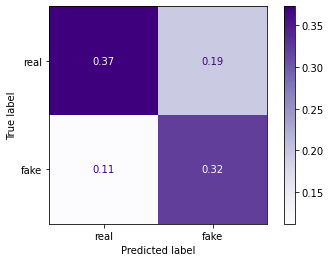

In [10]:
trainChart, predChart, confMtxPlot = modelData(articlesDF, stratify=False)
# Display the training data split
trainChart.display()

# Display highest weighted coefficients
predChart.display()

# Show the confusion matrix
confMtxPlot;

#### Features: Add punctuation

In [11]:
# Using these eight punctuation marks
punctString = '.,-?!:;"'    # period, comma, dash, question mark, exclamation mark, colon, semi-colon, quotes

# Count and add to a new column as a dictionary
# Counts are normalized by the lengths of the articles
articlesDF['accPunctDict'] = articlesDF.Text.apply(lambda s: {k:(v/len(s)) for k, v in Counter(s).items() if k in punctString})

# Convert the new column to a dataframe
punctDF = articlesDF.accPunctDict.apply(pd.Series)

# Merge with original dataframe,
# drop unnecessary column,
# and fill Nans with 0 (i.e. zero counts)
articlesDF = pd.concat([articlesDF, punctDF], axis=1)
articlesDF = articlesDF.drop(['accPunctDict'], axis=1)
articlesDF = articlesDF.fillna(0)

# Rename the columns to something readable
articlesDF = articlesDF.rename(columns={'"': 'DblQuote', '.': 'Period', '-': 'Dash', ',': 'Comma',
                                            '!': 'ExclMark', ';': 'SemiCol', ':': 'Colon', '?': 'QuesMark'})

articlesDF.head()

,Text,Domain,intLabel,Comma,Period,DblQuote,Dash,QuesMark,Colon,ExclMark,SemiCol
0,Supreme Court Forces Schools Into Socialism\n\...,edu,1,0.004603,0.011507,0.013809,0.001151,0.000000,0.000000,0.0,0.0
1,Brexit fist lost\nThe oil-rich Gulf country Qa...,biz,1,0.001245,0.008717,0.000000,0.001245,0.000000,0.000000,0.0,0.0
2,Leftist universities seek to put women in posi...,edu,1,0.007067,0.005300,0.003534,0.001767,0.001767,0.000000,0.0,0.0
3,New intelligence suggests ISIS rigging laptop ...,tech,1,0.003831,0.006386,0.002554,0.000000,0.000000,0.000000,0.0,0.0
4,Microsoft Aims to spread liberalism on the suc...,edu,1,0.001346,0.006729,0.013459,0.001346,0.000000,0.001346,0.0,0.0


Training and test dataframe shapes: (784, 11) (196, 11)
Fake (1) / real (0) label counts in the training data: Counter({1: 405, 0: 379})


Random f1 score: 0.5340909090909091 ... Accuracy: 0.5816326530612245
Logistic regression f1 score: 0.700507614213198 ... Accuracy: 0.6989795918367347
SVC f1 score: 0.7076923076923078 ... Accuracy: 0.7091836734693877




alt.HConcatChart(...)

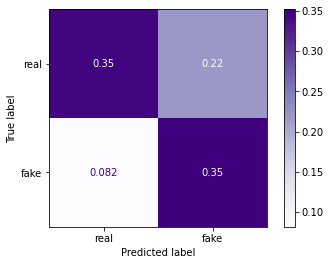

In [12]:
trainChart, predChart, confMtxPlot = modelData(articlesDF, stratify=False)
# Not displaying the same training data split
# Just the weights chart
predChart.display()

# Show the confusion matrix
confMtxPlot;

#### Features: Add Empath categories

In [13]:
# Create six new categories

# 1- Hedge ==> false
lexicon.create_category("hedge",['wonder', 'could', 'sort_of', 'maybe', 'possibly', 'just',
                                 'feel', 'reckon', 'generally_agreed'])
# 2- Modality ==> true/false
lexicon.create_category("modality",["could","may","possibly"])
# 3- Negation ==> truthful
lexicon.create_category("negation",['no', 'not', 'never', 'none', 'nobody', "n't", 'hardly', 'rarely', 'seldom', 'scarcely'])
# 4- Polarity ==> truthful
lexicon.create_category("polarity", ['accurate', 'inaccurate', 'uncertain', 'certain', 'likely', 'unlikely',
                                                              'probable', 'improbable', 'possible', 'impossible'])
# 5- Spatial ==> truthful
lexicon.create_category("spatial",["big","small","circular"])
# 6- Subjectivity ==> truthful
lexicon.create_category("subjectivity", ['abhorrent', 'abominable', 'brutal', 'coercive', 'disconcerting',
                                            'grateful', 'indecision', 'miserable', 'plausible', 'reflective'])


# List of categories (total of 14) to use as features, including six new ones
featCategs = ['anticipation', 'hedge', 'joy', 'modality', 'negation', 'negative_emotion', 'noise', 'party', 'polarity',
                          'positive_emotion', 'spatial', 'subjectivity', 'torment', 'vehicle']



["feel", "though", "wonder", "maybe", "thought", "wish", "probably", "Because", "might", "Maybe", "actually", "knew", "honestly", "knowing", "mean", "should", "wanted", "seem", "anything", "Sometimes", "guess", "though", "Or", "possibly", "suppose", "imagine", "anymore", "anyway", "If", "always", "sure", "bet", "thinking", "someone", "understand", "realize", "cause", "else", "sometimes", "Honestly", "care", "better", "anyone", "doubt", "realise", "meant", "either", "Even", "help", "try", "does", "better", "Now", "only", "cause", "figured", "right", "feels"]
["might", "may", "possibly", "should", "'d", "must", "able", "wanted", "ought", "willing", "surely", "couldn\u2019t", "otherwise", "wish", "wo", "Could", "If", "wouldn\u2019t", "other_ways", "suppose", "potentially", "capability", "Though", "wished", "couldn\u2019t", "Nor", "though", "needed", "enough", "ability", "didn\u2019t", "couldn&acirc;&euro;&trade;t", "potential", "Although", "meant", "although", "any", "even_I", "couldn&rsq

In [14]:
# Count and add to a new column as a dictionary
# Counts are normalized by the lengths of the articles
articlesDF['lexDict'] = articlesDF.Text.apply(lambda s: lexicon.analyze(s, categories=featCategs, normalize=True))

# Convert the new column to a dataframe
lexDF = articlesDF.lexDict.apply(pd.Series)

# Merge with original dataframe,
# drop unnecessary column,
# and fill Nans with 0 (i.e. zero counts)
articlesDF = pd.concat([articlesDF, lexDF], axis=1)
articlesDF = articlesDF.drop(['lexDict'], axis=1)
articlesDF = articlesDF.fillna(0)

articlesDF.head(1)

,Text,Domain,intLabel,Comma,Period,DblQuote,Dash,QuesMark,Colon,ExclMark,...,negation,negative_emotion,noise,party,polarity,positive_emotion,spatial,subjectivity,torment,vehicle
0,Supreme Court Forces Schools Into Socialism\n\...,edu,1,0.004603,0.011507,0.013809,0.001151,0.0,0.0,0.0,...,0.007752,0.0,0.0,0.0,0.015504,0.0,0.0,0.007752,0.0,0.0


Training and test dataframe shapes: (784, 25) (196, 25)
Fake (1) / real (0) label counts in the training data: Counter({1: 405, 0: 379})


Random f1 score: 0.5340909090909091 ... Accuracy: 0.5816326530612245
Logistic regression f1 score: 0.6979166666666667 ... Accuracy: 0.7040816326530612
SVC f1 score: 0.7046632124352332 ... Accuracy: 0.7091836734693877




alt.HConcatChart(...)

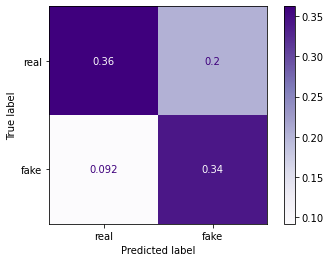

In [15]:
trainChart, predChart, confMtxPlot = modelData(articlesDF, stratify=False)
# Not displaying the same training data split
# Just the weights chart
predChart.display()

# Show the confusion matrix
confMtxPlot;

### **Scattertext**

In [16]:
# Form a complete list of terms from the Empath categories used above
termList = []
for eaCateg in featCategs:
  termList.extend(lexicon.cats[eaCateg][:10])
# Add terms from feature weights above
moreTerms = ['said', 'source', 'insider', 'year', 'night', 'day', 'revealed',
             'like', 'people', 'world', 'old', 'way', 'wants', 'like']
termList.extend(moreTerms)
# Convert to a set to remove possible duplicates
termList = set(termList)


# Read in the data again to get the original labels
scatterDF = pd.read_csv(inFile, index_col=0)

scatterDF = scatterDF.assign(
    parse=lambda scatterDF: scatterDF.Text.apply(st.whitespace_nlp_with_sentences)
)

corpus = st.CorpusFromParsedDocuments(
    scatterDF, category_col='Label', parsed_col='parse'
).build().get_unigram_corpus().compact(st.AssociationCompactor(2000))

# Generate the scatter plot data
scatterData = st.produce_scattertext_explorer(
    corpus,
    category='fake', category_name='Fake', not_category_name='Real',
    minimum_term_frequency=0, pmi_threshold_coefficient=0,
    return_data=True,
    transform=st.Scalers.dense_rank
)
# Put it into a dataframe, filter out labels
# for terms not in termList
scatterPlotDF = pd.DataFrame(scatterData['data'])
scatterPlotDF['plotTerm'] = scatterPlotDF['term'].apply(lambda x: x if x in termList else ' ')
# Also filter out labels for terms too close
# to the origin and so not legible
scatterPlotDF['plotTerm'] = scatterPlotDF[['ox','oy', 'plotTerm']] \
                                .apply(lambda x: x['plotTerm'] if (x['oy']>0.25) else ' ', axis=1)

scatterPlot = alt.Chart(scatterPlotDF).mark_circle().encode(
    x = alt.X('x:Q', title='\u21e6 less with real | more with real \u21e8', axis=alt.Axis(tickMinStep=0.1)),
    y = alt.Y('y:Q', title='\u21e6 less with fake | more with fake \u21e8', axis=alt.Axis(tickMinStep=0.1)),
    color = alt.Color('s', scale=alt.Scale(scheme='redyellowgreen', reverse=True),
                      legend=alt.Legend(title=["Fake vs real", "frequency"])),
).properties(
    width = 500,
    height = 500
)

text = alt.Chart(scatterPlotDF).mark_text(
    align='left',
    baseline='middle',
    dx=7,
    color='black'
).encode(
    x = alt.X('x:Q'),
    y = alt.Y('y:Q'),
    text='plotTerm'
).properties(
    title = 'How frequently are terms used with each type of news?',
    width = 500,
    height = 500
)

(scatterPlot + text).configure_axis(
    labelFontSize=10,
    titleFontSize=12
).configure_title(
    fontSize=15,
    anchor='start'
).configure_legend(
    titleFontSize=12
)


alt.LayerChart(...)